In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim
import torch.nn as nn
import numpy as np
import torchvision
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)

# data (as pandas dataframes)
df_full=parkinsons_telemonitoring.data.original

X=df_full.drop(columns=['motor_UPDRS','total_UPDRS'])
y_motor=df_full['motor_UPDRS']
y_total=df_full['total_UPDRS']



Now we define the first model for the comparison: a simple MLP.
The task in this case is a point to point regression.
This model is a simple baseline, it will have mediocre performance

In [ ]:
#First, data preprocessing:
#drop columns we don't need and the targets
features_mlp=df_full.drop(columns=['subject#','motor_UPDRS','total_UPDRS'])
#and focus on one target, if regression on the other target is needed simply change this line
target_mlp=df_full['motor_UPDRS']

#Then divide the data in train an testing and use a Standard Scaler to scale it
X_train, X_test, y_train, y_test = train_test_split(features_mlp, target_mlp, test_size=0.2, random_state=42)
scaler=StandardScaler()
y_scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test=y_scaler.transform(y_test.values.reshape(-1,1))

#convert data to tensor and create dataloaders
X_train=torch.tensor(X_train,dtype=torch.float32)
y_train=torch.tensor(y_train,dtype=torch.float32)

dataset=TensorDataset(X_train,y_train)
loader=DataLoader(dataset,batch_size=32,shuffle=True)

test_dataset=TensorDataset(torch.tensor(X_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
#Then define the model
class MLP(torch.nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        return self.model(x)


model=MLP(input_dim=X_train.shape[1])
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

#Training has the same number of epochs for every model
for epoch in range(2000):
    total_loss=0
    for xb,yb in loader:
        output=model(xb)
        loss=model.loss_fn(output,yb)
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        total_loss+=loss.item()*xb.size(0)

    if (epoch + 1) % 20 == 0:
        print(f"RNN Epoch {epoch+1}, Loss: {total_loss:.4f}")



RNN Epoch 20, Loss: 2733.3629
RNN Epoch 40, Loss: 2026.4714
RNN Epoch 60, Loss: 1754.8230
RNN Epoch 80, Loss: 1578.8034
RNN Epoch 100, Loss: 1439.5127
RNN Epoch 120, Loss: 1330.9364
RNN Epoch 140, Loss: 1234.7251
RNN Epoch 160, Loss: 1162.5026
RNN Epoch 180, Loss: 1095.0556
RNN Epoch 200, Loss: 1036.8770
RNN Epoch 220, Loss: 986.9058
RNN Epoch 240, Loss: 941.5903
RNN Epoch 260, Loss: 898.9841
RNN Epoch 280, Loss: 856.0797
RNN Epoch 300, Loss: 816.2826
RNN Epoch 320, Loss: 785.2101
RNN Epoch 340, Loss: 755.8938
RNN Epoch 360, Loss: 726.2694
RNN Epoch 380, Loss: 702.5551
RNN Epoch 400, Loss: 677.3685
RNN Epoch 420, Loss: 661.1585
RNN Epoch 440, Loss: 638.4162
RNN Epoch 460, Loss: 623.0845
RNN Epoch 480, Loss: 607.6916
RNN Epoch 500, Loss: 590.0306
RNN Epoch 520, Loss: 575.8425
RNN Epoch 540, Loss: 563.9541
RNN Epoch 560, Loss: 549.6637
RNN Epoch 580, Loss: 537.9295
RNN Epoch 600, Loss: 529.8067
RNN Epoch 620, Loss: 518.8850
RNN Epoch 640, Loss: 507.8366
RNN Epoch 660, Loss: 495.1279
RNN 

Test MSE: 12.00
Test MAE: 2.41
R² Score: 0.8121


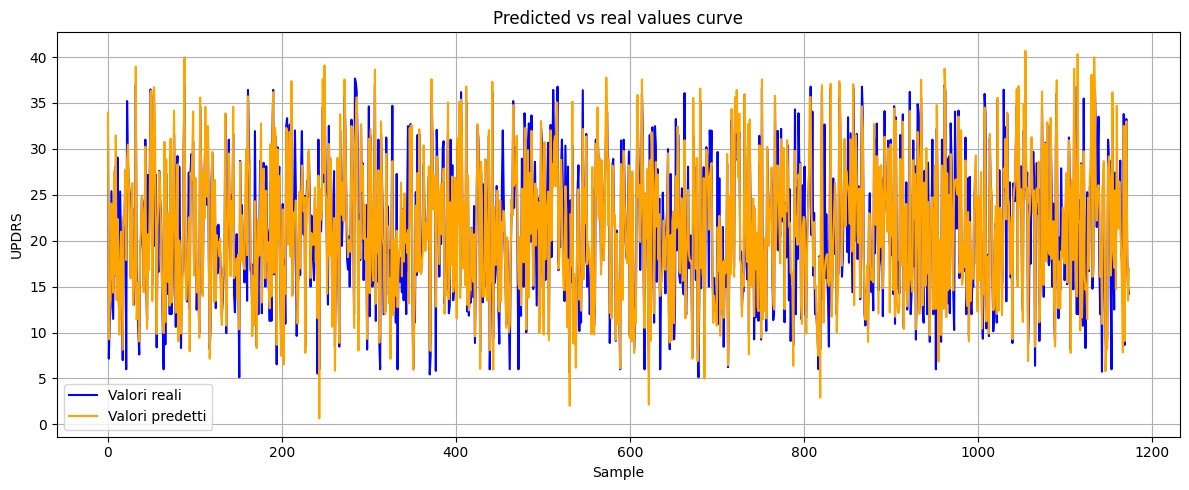

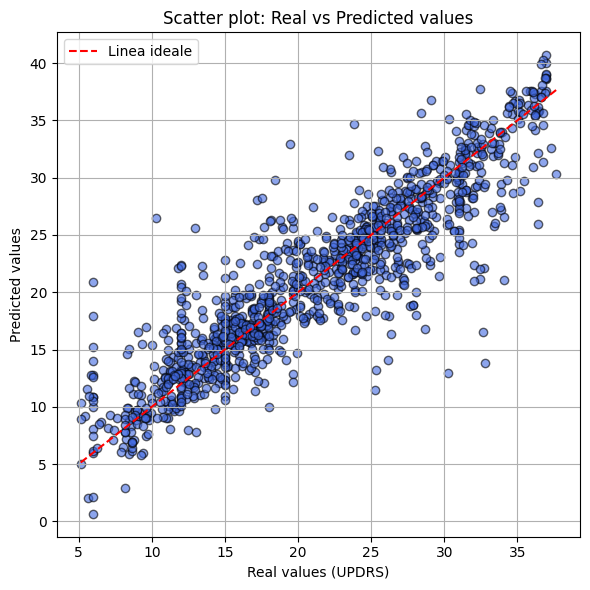

In [ ]:
#Then define the function for testing
def test_model(model, test_loader, loss_fn,scaler_y):
  model.eval()
  y_true_list=[]
  y_pred_list=[]

  with torch.no_grad():
    total_loss=0
    for xb,yb in test_loader:
      pred=model(xb)
      y_pred_list.append(pred.numpy())
      y_true_list.append(yb.numpy())

  y_pred = np.concatenate(y_pred_list, axis=0)
  y_true = np.concatenate(y_true_list, axis=0)

  #bring back data to an interpretable form
  y_pred_rescaled = scaler_y.inverse_transform(y_pred)
  y_true_rescaled = scaler_y.inverse_transform(y_true)

  mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
  mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
  r2 = r2_score(y_true_rescaled, y_pred_rescaled)

  print(f"Test MSE: {mse:.2f}")
  print(f"Test MAE: {mae:.2f}")
  print(f"R² Score: {r2:.4f}")
  #First a simple line plot
  plt.figure(figsize=(12, 5))
  plt.plot(y_true_rescaled, label="Real values", color="blue")
  plt.plot(y_pred_rescaled, label="Predicted values", color="orange")
  plt.title("Predicted vs real values curve")
  plt.xlabel("Sample")
  plt.ylabel("UPDRS")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  #Scatter
  plt.figure(figsize=(6, 6))
  plt.scatter(y_true_rescaled, y_pred_rescaled, alpha=0.6, color="royalblue", edgecolors='k')
  plt.plot([y_true_rescaled.min(), y_true_rescaled.max()],
         [y_true_rescaled.min(), y_true_rescaled.max()],
         color='red', linestyle='--', label="Linea ideale")

  plt.title("Scatter plot: Real vs Predicted values")
  plt.xlabel("Real values (UPDRS)")
  plt.ylabel("Predicted values")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

test_model(model, test_loader,loss_fn,y_scaler)

Now implementing the RNN model

In [ ]:
#First data processing and organizzation
#group data by subject
df_grouped=df_full.groupby('subject#')

#sliding windows parameters
window_size=5
target_col="motor_UPDRS"

#empty lists where put data in sequences
X_seq=[]
y_seq=[]

#per ogni paziente
for subject_id, df_subject in df_grouped:
  group_sorted=df_subject.sort_values("test_time").reset_index(drop=True)

  features=group_sorted.drop(columns=['subject#','test_time','motor_UPDRS','total_UPDRS'])
  target=group_sorted[target_col]
  #for every i with at least five following entries
  for i in range(len(features)-window_size):
    X_seq.append(features[i:i+window_size]) #append that five following entries to the list as a single entry
    y_seq.append(target[i+window_size])

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
#split the data and transform the splitted data in tensors
X_seq_train=np.array(X_seq)
y_seq_train=np.array(y_seq)
X_seq_test=np.array(X_seq)
y_seq_test=np.array(y_seq)

# Scale x
num_features = X_seq_train.shape[2]
X_flat_train = X_seq_train.reshape(-1, num_features)
scaler_X = StandardScaler().fit(X_flat_train)

X_flat_train_scaled = scaler_X.transform(X_flat_train)
X_flat_test_scaled = scaler_X.transform(X_seq_test.reshape(-1, num_features))

X_seq_train_scaled = torch.tensor(X_flat_train_scaled.reshape(X_seq_train.shape), dtype=torch.float32)
X_seq_test_scaled = torch.tensor(X_flat_test_scaled.reshape(X_seq_test.shape), dtype=torch.float32)

# Scale y and create dataloaders
scaler_y = StandardScaler().fit(y_seq_train.reshape(-1, 1))
y_seq_train_scaled = torch.tensor(scaler_y.transform(y_seq_train.reshape(-1, 1)), dtype=torch.float32)
y_seq_test_scaled = torch.tensor(scaler_y.transform(y_seq_test.reshape(-1, 1)), dtype=torch.float32)

train_dataset = TensorDataset(X_seq_train_scaled, y_seq_train_scaled)
test_dataset = TensorDataset(X_seq_test_scaled, y_seq_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
class RNN(nn.Module):
  def __init__(self,input_dim,hidden_dim):
    super(RNN,self).__init__()
    self.hidden_dim=hidden_dim
    self.input_dim=input_dim

    #Define the weights:
    self.Wxh=nn.Linear(input_dim,hidden_dim)
    self.Whh=nn.Linear(hidden_dim,hidden_dim, bias=False)
    self.tanh=nn.Tanh()

    #output
    self.output=nn.Linear(hidden_dim,1)

  def forward(self,x):
    batch_size, seq_len, _= x.shape # Added seq_len dimension
    h=torch.zeros(batch_size,self.Wxh.out_features, device=x.device) # Initialize hidden state on the same device as input

    for t in range(seq_len):
      x_t=x[:, t, :]
      h= self.tanh(self.Wxh(x_t)+self.Whh(h))

    output=self.output(h)
    return output

rnn=RNN(input_dim=18,hidden_dim=32)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.001)

#training loop
num_epochs=2000
losses=[]

for epoch in range(num_epochs):
  total_loss=0
  for xb,yb in train_loader:
    pred = rnn(xb) # Use the RNN model
    loss=loss_fn(pred,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()*xb.size(0)

  losses.append(total_loss/len(train_loader.dataset))
  if (epoch + 1) % 10 == 0:
    print(f"RNN Epoch {epoch+1}, Loss: {total_loss:.4f}")

NameError: name 'train_loader' is not defined

In [ ]:
#now the test phase
def test_model(model, test_loader, loss_fn,scaler_y):
  model.eval()
  y_true_list=[]
  y_pred_list=[]

  with torch.no_grad():
    total_loss=0
    for xb,yb in test_loader:
      pred=model(xb)
      y_pred_list.append(pred.numpy())
      y_true_list.append(yb.numpy())

  y_pred = np.concatenate(y_pred_list, axis=0)
  y_true = np.concatenate(y_true_list, axis=0)

  y_pred_rescaled = scaler_y.inverse_transform(y_pred)
  y_true_rescaled = scaler_y.inverse_transform(y_true)

  mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
  mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
  r2 = r2_score(y_true_rescaled, y_pred_rescaled)

  print(f"Test MSE: {mse:.2f}")
  print(f"Test MAE: {mae:.2f}")
  print(f"R² Score: {r2:.4f}")
  plt.figure(figsize=(12, 5))
  plt.plot(y_true_rescaled, label="Real values", color="blue")
  plt.plot(y_pred_rescaled, label="Predicted Values", color="orange")
  plt.title("Predicted vs real values curve")
  plt.xlabel("Sample")
  plt.ylabel("UPDRS")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  #Scatter
  plt.figure(figsize=(6, 6))
  plt.scatter(y_true_rescaled, y_pred_rescaled, alpha=0.6, color="royalblue", edgecolors='k')
  plt.plot([y_true_rescaled.min(), y_true_rescaled.max()],
         [y_true_rescaled.min(), y_true_rescaled.max()],
         color='red', linestyle='--', label="Linea ideale")

  plt.title("Scatter plot: Real vs Predicted values")
  plt.xlabel("Real values (UPDRS)")
  plt.ylabel("Predicted values")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

test_model(model, test_loader,loss_fn, scaler_y)

3# LSTM model

In [ ]:
#First data processing and organizzation

df_grouped=df_full.groupby('subject#')

#sliding window parameters
window_size=5
target_col="motor_UPDRS"


X_seq=[]
y_seq=[]

#preprocessing to convert data in to sequences is the same as for the RNN
for subject_id, df_subject in df_grouped:
  group_sorted=df_subject.sort_values("test_time").reset_index(drop=True)

  features=group_sorted.drop(columns=['subject#','test_time','motor_UPDRS','total_UPDRS'])
  target=group_sorted[target_col]

  for i in range(len(features)-window_size):
    X_seq.append(features[i:i+window_size])
    y_seq.append(target[i+window_size])

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X_seq_train=np.array(X_seq)
y_seq_train=np.array(y_seq)
X_seq_test=np.array(X_seq)
y_seq_test=np.array(y_seq)

# Normalizza X
num_features = X_seq_train.shape[2]
X_flat_train = X_seq_train.reshape(-1, num_features)
scaler_X = StandardScaler().fit(X_flat_train)

X_flat_train_scaled = scaler_X.transform(X_flat_train)
X_flat_test_scaled = scaler_X.transform(X_seq_test.reshape(-1, num_features))

X_seq_train_scaled = torch.tensor(X_flat_train_scaled.reshape(X_seq_train.shape), dtype=torch.float32)
X_seq_test_scaled = torch.tensor(X_flat_test_scaled.reshape(X_seq_test.shape), dtype=torch.float32)

# Normalizza y
scaler_y = StandardScaler().fit(y_seq_train.reshape(-1, 1))
y_seq_train_scaled = torch.tensor(scaler_y.transform(y_seq_train.reshape(-1, 1)), dtype=torch.float32)
y_seq_test_scaled = torch.tensor(scaler_y.transform(y_seq_test.reshape(-1, 1)), dtype=torch.float32)

train_dataset = TensorDataset(X_seq_train_scaled, y_seq_train_scaled)
test_dataset = TensorDataset(X_seq_test_scaled, y_seq_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Then we define the model:

In [ ]:
class LSTM(nn.Module):
  def __init__(self,input_dim,hidden_dim):
    super(LSTM,self).__init__()
    self.hidden_dim=hidden_dim
    self.input_dim=input_dim

    self.Wf=nn.Linear(input_dim+hidden_dim,hidden_dim)#forget
    self.Wi=nn.Linear(input_dim+hidden_dim,hidden_dim)#input
    self.Wc=nn.Linear(input_dim+hidden_dim,hidden_dim)#cell
    self.Wo=nn.Linear(input_dim+hidden_dim,hidden_dim)#output

    self.tanh=nn.Tanh()
    self.sigmoid=nn.Sigmoid()
    #output of the model
    self.output=nn.Linear(hidden_dim,1)

  def forward(self,x,initial_hidden,initial_cell):
    batch_size, seq_len, _= x.shape
    hidden=initial_hidden
    cell=initial_cell

    for t in range(seq_len):
      x_t=x[:, t, :]
      concat=torch.cat((x_t,hidden),dim=1)
      forget=self.sigmoid(self.Wf(concat))
      input=self.sigmoid(self.Wi(concat))
      candidate=self.tanh(self.Wc(concat))

      output_gate=self.sigmoid(self.Wo(concat))
      cell=forget*cell+input*candidate
      hidden=output_gate*self.tanh(cell)

    output=self.output(hidden)

    return output,hidden,cell


ltsm=LSTM(input_dim=18,hidden_dim=32)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(ltsm.parameters(),lr=0.001) # Optimizer for the model

Now training the model:

In [ ]:
#training loop
num_epochs=2000
losses=[]

for epoch in range(num_epochs):
  total_loss=0
  for xb,yb in train_loader:
    hidden=torch.zeros(xb.size(0), ltsm.hidden_dim, device=xb.device)
    cell=torch.zeros(xb.size(0), ltsm.hidden_dim, device=xb.device)
    pred,hidden,cell = ltsm(xb,hidden,cell) # Use the lstm
    loss=loss_fn(pred,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()*xb.size(0)

  losses.append(total_loss/len(train_loader.dataset))
  if (epoch + 1) % 10 == 0:
    print(f"RNN Epoch {epoch+1}, Loss: {total_loss:.4f}")

RNN Epoch 10, Loss: 1013.4844
RNN Epoch 20, Loss: 629.5981
RNN Epoch 30, Loss: 452.0581
RNN Epoch 40, Loss: 354.1425
RNN Epoch 50, Loss: 296.1481
RNN Epoch 60, Loss: 259.3286
RNN Epoch 70, Loss: 260.8110
RNN Epoch 80, Loss: 203.8241
RNN Epoch 90, Loss: 187.1796
RNN Epoch 100, Loss: 171.0524
RNN Epoch 110, Loss: 153.0924
RNN Epoch 120, Loss: 160.5637
RNN Epoch 130, Loss: 128.2589
RNN Epoch 140, Loss: 121.1756
RNN Epoch 150, Loss: 116.0500
RNN Epoch 160, Loss: 106.0173
RNN Epoch 170, Loss: 98.5647
RNN Epoch 180, Loss: 92.7648
RNN Epoch 190, Loss: 90.9613
RNN Epoch 200, Loss: 87.2185
RNN Epoch 210, Loss: 80.7709
RNN Epoch 220, Loss: 73.4966
RNN Epoch 230, Loss: 70.0291
RNN Epoch 240, Loss: 67.3981
RNN Epoch 250, Loss: 60.3898
RNN Epoch 260, Loss: 57.0133
RNN Epoch 270, Loss: 57.1578
RNN Epoch 280, Loss: 53.9575
RNN Epoch 290, Loss: 53.4664
RNN Epoch 300, Loss: 52.7031
RNN Epoch 310, Loss: 47.9265
RNN Epoch 320, Loss: 44.5333
RNN Epoch 330, Loss: 41.3185
RNN Epoch 340, Loss: 44.0361
RNN Ep

Test MSE: 0.04
Test MAE: 0.15
R² Score: 0.9994


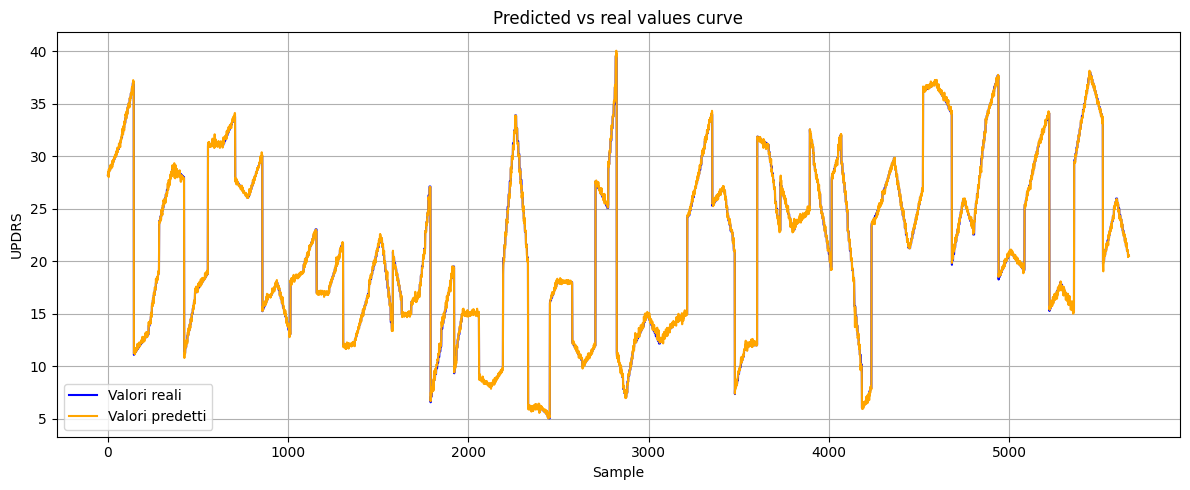

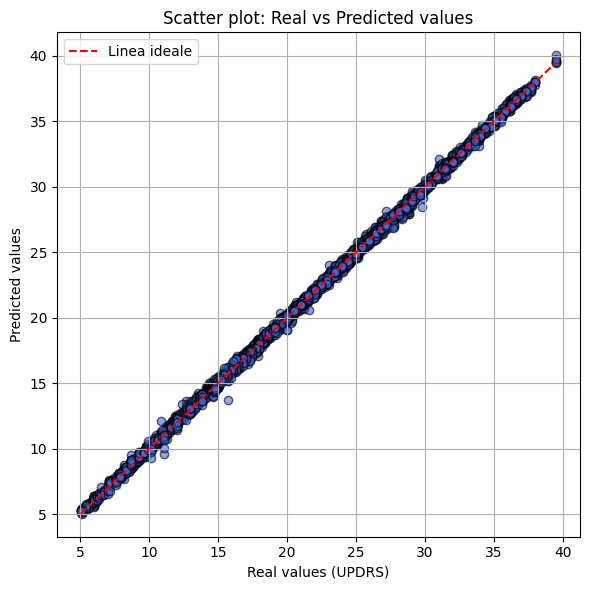

In [ ]:
#now the test phase
def test_model(model, test_loader, loss_fn,scaler_y):
  model.eval()
  y_true_list=[]
  y_pred_list=[]

  with torch.no_grad():
    total_loss=0
    for xb,yb in test_loader:
      pred,_,_=model(xb,torch.zeros(xb.size(0), model.hidden_dim, device=xb.device), torch.zeros(xb.size(0), model.hidden_dim, device=xb.device))
      y_pred_list.append(pred.numpy())
      y_true_list.append(yb.numpy())

  y_pred = np.concatenate(y_pred_list, axis=0)
  y_true = np.concatenate(y_true_list, axis=0)

  y_pred_rescaled = scaler_y.inverse_transform(y_pred)
  y_true_rescaled = scaler_y.inverse_transform(y_true)

  mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
  mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
  r2 = r2_score(y_true_rescaled, y_pred_rescaled)

  print(f"Test MSE: {mse:.2f}")
  print(f"Test MAE: {mae:.2f}")
  print(f"R² Score: {r2:.4f}")
  plt.figure(figsize=(12, 5))
  plt.plot(y_true_rescaled, label="Real values", color="blue")
  plt.plot(y_pred_rescaled, label="Predicted values", color="orange")
  plt.title("Predicted vs real values curve")
  plt.xlabel("Sample")
  plt.ylabel("UPDRS")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  #Scatter
  plt.figure(figsize=(6, 6))
  plt.scatter(y_true_rescaled, y_pred_rescaled, alpha=0.6, color="royalblue", edgecolors='k')
  plt.plot([y_true_rescaled.min(), y_true_rescaled.max()],
         [y_true_rescaled.min(), y_true_rescaled.max()],
         color='red', linestyle='--', label="Linea ideale")

  plt.title("Scatter plot: Real vs Predicted values")
  plt.xlabel("Real values (UPDRS)")
  plt.ylabel("Predicted values")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

test_model(ltsm, test_loader,loss_fn, scaler_y)

now we implement the attention mechanism in the lstm architecture.

In [ ]:
#first define and train a similar lstm model, with one small difference
class LSTM_for_attention(nn.Module):
  def __init__(self,input_dim,hidden_dim):
    super(LSTM_for_attention,self).__init__()
    self.hidden_dim=hidden_dim
    self.input_dim=input_dim

    self.Wf=nn.Linear(input_dim+hidden_dim,hidden_dim) #forget
    self.Wi=nn.Linear(input_dim+hidden_dim,hidden_dim)#input
    self.Wc=nn.Linear(input_dim+hidden_dim,hidden_dim)#cell
    self.Wo=nn.Linear(input_dim+hidden_dim,hidden_dim)#output

    self.tanh=nn.Tanh()
    self.sigmoid=nn.Sigmoid()
    #output
    self.output=nn.Linear(hidden_dim,1)

  def forward(self,x,initial_hidden,initial_cell):
    batch_size, seq_len, _= x.shape
    hidden=initial_hidden
    cell=initial_cell
    hidden_seq=[] #we need a sequence accumulating all the hidden states we compute
    for t in range(seq_len):
      x_t=x[:, t, :]
      concat=torch.cat((x_t,hidden),dim=1)
      forget=self.sigmoid(self.Wf(concat))
      input=self.sigmoid(self.Wi(concat))
      candidate=self.tanh(self.Wc(concat))

      output_gate=self.sigmoid(self.Wo(concat))
      cell=forget*cell+input*candidate
      hidden=output_gate*self.tanh(cell)
      hidden_seq.append(hidden.unsqueeze(1))  #shape [batch,1,hidden_dim]

    hidden_seq=torch.cat(hidden_seq,dim=1) #shape [batch,seq_len,hidden_dim]
    #output=self.output(hidden)   NO NEED FOR THIS OUTPUT

    return hidden_seq,hidden,cell


class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super.__init__()
        self.hidden_dim = hidden_dim
        self.lstm=LSTM_for_attention(input_dim=18,hidden_dim=32)
        self.attention = nn.Linear(hidden_dim, 1)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x, initial_hidden, initial_cell):
        #x: [batch_size,sew_len,input_dim]
        lstm_out=self.lstm(x,initial_hidden,initial_cell)

        #attention weights
        attn_weights=torch.softmax(self.attention(lstm_out),dim=1)

        #context vector
        context=torch.sum(attn_weights*lstm_out,dim=1)

        #output
        output=self.output(context)
        return output

A_lstm=LSTM(input_dim=18,hidden_dim=32)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(A_lstm.parameters(),lr=0.001) # Optimizer for the model

Qui il ciclo di training:

In [ ]:
#training loop
num_epochs=2000
losses=[]

for epoch in range(num_epochs):
  total_loss=0
  for xb,yb in train_loader:
    hidden=torch.zeros(xb.size(0), ltsm.hidden_dim, device=xb.device)
    cell=torch.zeros(xb.size(0), ltsm.hidden_dim, device=xb.device)
    pred,hidden,cell = A_lstm(xb,hidden,cell) # Use the model
    loss=loss_fn(pred,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # Call optimizer.step() as a function
    total_loss+=loss.item()*xb.size(0)

  losses.append(total_loss/len(train_loader.dataset))
  if (epoch + 1) % 10 == 0:
    print(f"RNN Epoch {epoch+1}, Loss: {total_loss:.4f}")

RNN Epoch 10, Loss: 982.0283
RNN Epoch 20, Loss: 623.3735
RNN Epoch 30, Loss: 483.6871
RNN Epoch 40, Loss: 369.3612
RNN Epoch 50, Loss: 315.4178
RNN Epoch 60, Loss: 279.0913
RNN Epoch 70, Loss: 244.8518
RNN Epoch 80, Loss: 234.8027
RNN Epoch 90, Loss: 212.9777
RNN Epoch 100, Loss: 184.9172
RNN Epoch 110, Loss: 172.7673
RNN Epoch 120, Loss: 155.9605
RNN Epoch 130, Loss: 149.0539
RNN Epoch 140, Loss: 140.9767
RNN Epoch 150, Loss: 124.8462
RNN Epoch 160, Loss: 131.8433
RNN Epoch 170, Loss: 108.3419
RNN Epoch 180, Loss: 108.2521
RNN Epoch 190, Loss: 93.5427
RNN Epoch 200, Loss: 88.7958
RNN Epoch 210, Loss: 82.5887
RNN Epoch 220, Loss: 78.6807
RNN Epoch 230, Loss: 76.8917
RNN Epoch 240, Loss: 72.1108
RNN Epoch 250, Loss: 68.7675
RNN Epoch 260, Loss: 64.0274
RNN Epoch 270, Loss: 65.7627
RNN Epoch 280, Loss: 61.0869
RNN Epoch 290, Loss: 56.1083
RNN Epoch 300, Loss: 56.5699
RNN Epoch 310, Loss: 50.0892
RNN Epoch 320, Loss: 49.0788
RNN Epoch 330, Loss: 49.3007
RNN Epoch 340, Loss: 44.0151
RNN E

Test MSE: 0.05
Test MAE: 0.16
R² Score: 0.9993


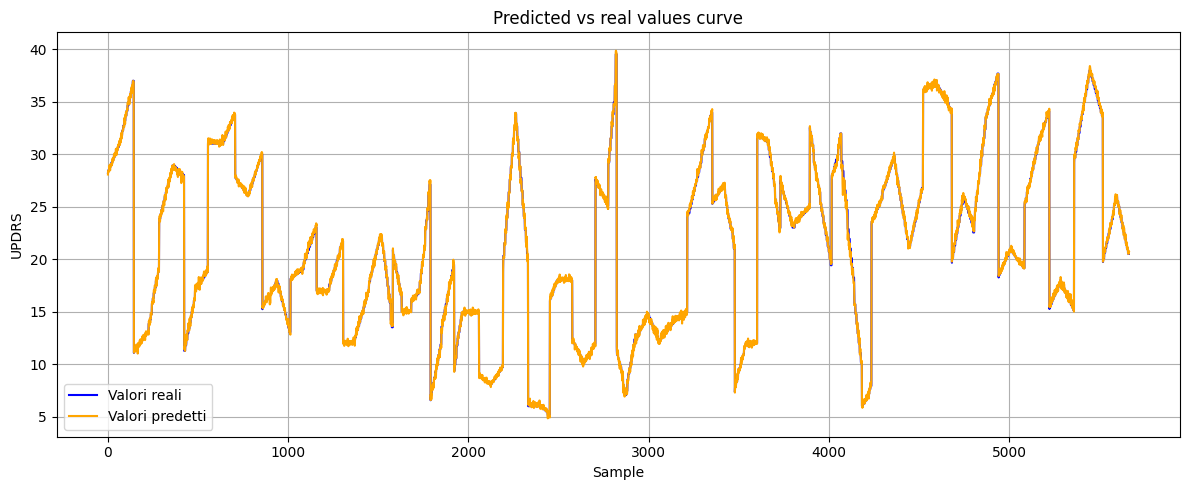

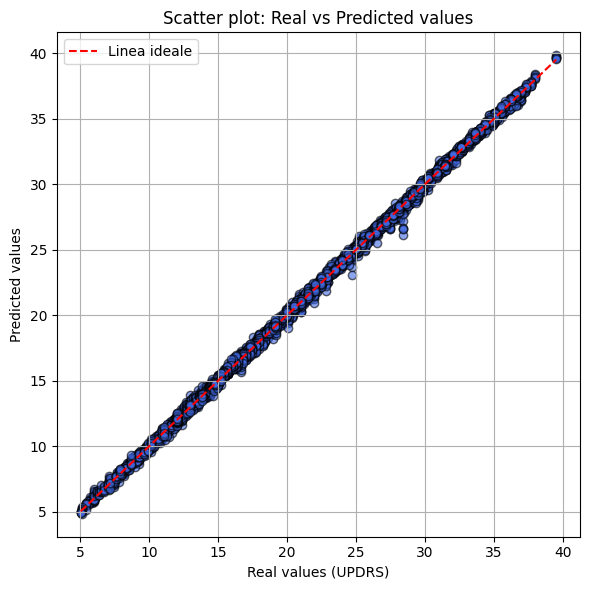

In [ ]:
#we use the same testing function as the previous model
test_model(A_lstm, test_loader,loss_fn, scaler_y)

The last model is a bidirectional lstm, we already have the lstm that reads normally (left to right), now we implement the other one that reads in reverse

In [ ]:
class LSTM_bw(nn.Module):
  def __init__(self,input_dim,hidden_dim):
    super(LSTM_bw,self).__init__()
    self.hidden_dim=hidden_dim
    self.input_dim=input_dim
    self.lstm_fw=LSTM(input_dim=18,hidden_dim=32)
    self.lstm_bw=LSTM(input_dim=18,hidden_dim=32)

    self.tanh=nn.Tanh()
    self.sigmoid=nn.Sigmoid()
    #output
    self.output=nn.Linear(hidden_dim*2,1) # Output dimension is hidden_dim*2

  def forward(self,x):
    batch_size, seq_len, _= x.shape
    h0 = torch.zeros(x.size(0), self.lstm_fw.hidden_dim, device=x.device)
    c0 = torch.zeros(x.size(0), self.lstm_fw.hidden_dim, device=x.device)

    _,hidden_fwd,_=self.lstm_fw(x,h0,c0) # Get the final hidden state
    _,hidden_bw,_=self.lstm_bw(torch.flip(x,[1]),h0,c0) # Get the final hidden state

    combined_hidden=torch.cat((hidden_fwd,hidden_bw),dim=1) # Concatenate along dimension 1

    return self.output(combined_hidden)

In [ ]:
bi_lstm=LSTM_bw(input_dim=18,hidden_dim=32)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(bi_lstm.parameters(),lr=0.001) # Optimizer for the model
num_epochs=2000
losses=[]
#Training loop
for epoch in range(num_epochs):
  total_loss=0
  for xb,yb in train_loader:
    pred = bi_lstm(xb) # Use the model, it returns only the prediction
    loss=loss_fn(pred,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # Call optimizer.step() as a function
    total_loss+=loss.item()*xb.size(0)

  losses.append(total_loss/len(train_loader.dataset))
  if (epoch + 1) % 10 == 0:
    print(f"RNN Epoch {epoch+1}, Loss: {total_loss:.4f}")

RNN Epoch 10, Loss: 823.4453
RNN Epoch 20, Loss: 499.2931
RNN Epoch 30, Loss: 372.1245
RNN Epoch 40, Loss: 293.0206
RNN Epoch 50, Loss: 263.9275
RNN Epoch 60, Loss: 194.4880
RNN Epoch 70, Loss: 172.3062
RNN Epoch 80, Loss: 143.7331
RNN Epoch 90, Loss: 122.7926
RNN Epoch 100, Loss: 114.4854
RNN Epoch 110, Loss: 110.7937
RNN Epoch 120, Loss: 85.6447
RNN Epoch 130, Loss: 77.0623
RNN Epoch 140, Loss: 67.3661
RNN Epoch 150, Loss: 59.5010
RNN Epoch 160, Loss: 51.6528
RNN Epoch 170, Loss: 48.6889
RNN Epoch 180, Loss: 43.1232
RNN Epoch 190, Loss: 40.4560
RNN Epoch 200, Loss: 36.3482
RNN Epoch 210, Loss: 35.4082
RNN Epoch 220, Loss: 33.1941
RNN Epoch 230, Loss: 26.8702
RNN Epoch 240, Loss: 27.0539
RNN Epoch 250, Loss: 28.6163
RNN Epoch 260, Loss: 21.0108
RNN Epoch 270, Loss: 19.0337
RNN Epoch 280, Loss: 26.8002
RNN Epoch 290, Loss: 15.2556
RNN Epoch 300, Loss: 16.4836
RNN Epoch 310, Loss: 18.3055
RNN Epoch 320, Loss: 14.7763
RNN Epoch 330, Loss: 15.7327
RNN Epoch 340, Loss: 31.2602
RNN Epoch 35

Test MSE: 0.02
Test MAE: 0.11
R² Score: 0.9997


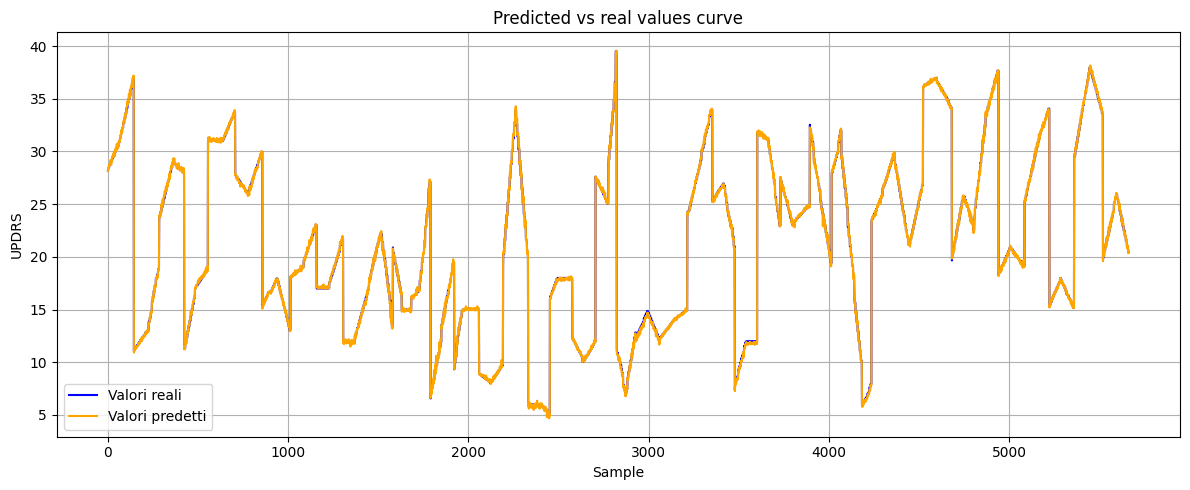

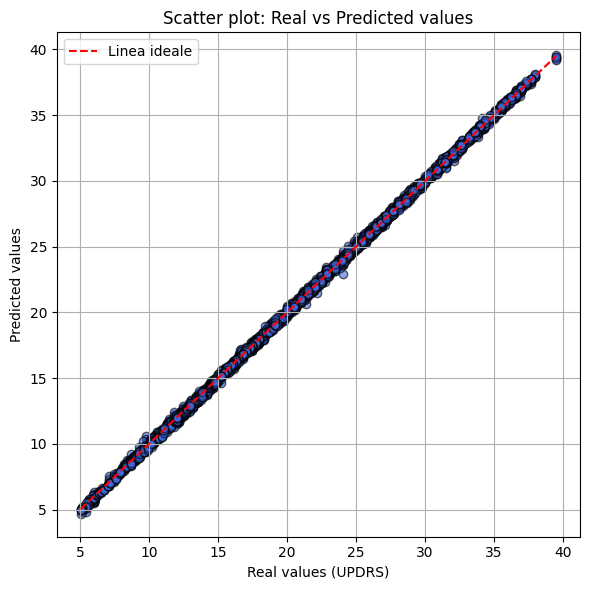

In [ ]:
#Now we test the model:
def test_model(model, test_loader, loss_fn,scaler_y):
  model.eval()
  y_true_list=[]
  y_pred_list=[]

  with torch.no_grad():
    total_loss=0
    for xb,yb in test_loader:
      pred=model(xb)
      y_pred_list.append(pred.numpy())
      y_true_list.append(yb.numpy())

  y_pred = np.concatenate(y_pred_list, axis=0)
  y_true = np.concatenate(y_true_list, axis=0)

  y_pred_rescaled = scaler_y.inverse_transform(y_pred)
  y_true_rescaled = scaler_y.inverse_transform(y_true)

  mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
  mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
  r2 = r2_score(y_true_rescaled, y_pred_rescaled)

  print(f"Test MSE: {mse:.2f}")
  print(f"Test MAE: {mae:.2f}")
  print(f"R² Score: {r2:.4f}")
  plt.figure(figsize=(12, 5))
  plt.plot(y_true_rescaled, label="Valori reali", color="blue")
  plt.plot(y_pred_rescaled, label="Valori predetti", color="orange")
  plt.title("Predicted vs real values curve")
  plt.xlabel("Sample")
  plt.ylabel("UPDRS")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  #Scatter
  plt.figure(figsize=(6, 6))
  plt.scatter(y_true_rescaled, y_pred_rescaled, alpha=0.6, color="royalblue", edgecolors='k')
  plt.plot([y_true_rescaled.min(), y_true_rescaled.max()],
         [y_true_rescaled.min(), y_true_rescaled.max()],
         color='red', linestyle='--', label="Linea ideale")

  plt.title("Scatter plot: Real vs Predicted values")
  plt.xlabel("Real values (UPDRS)")
  plt.ylabel("Predicted values")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

test_model(bi_lstm, test_loader,loss_fn, scaler_y)